# Učitavanje datoteka

In [1]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="my-test-project", entity="bresha")

wandb: Currently logged in as: bresha (use `wandb login --relogin` to force relogin)


In [2]:
import pandas as pd

In [3]:
download_url = "train.csv"

In [4]:
df = pd.read_csv(download_url)
df.job_functions = df.job_functions.apply(eval)
df.industries = df.industries.apply(eval)

df.head()

,job_title,seniority_level,employment_type,industries,job_functions
0,Manual Tester,Entry level,Full-time,[Information Technology and Services],"[Engineering, Information Technology]"
1,Field Marketing Representative,Entry level,Full-time,"[Food & Beverages, Wholesale, Retail]","[Marketing, Sales]"
2,Consumer Relations Representative,Associate,Full-time,"[Marketing and Advertising, Food & Beverages, ...",[Other]
3,Software Engineer In Test,Mid-Senior level,Full-time,"[Information Technology and Services, Computer...","[Information Technology, Quality Assurance]"
4,Electrician,Entry level,Full-time,"[Electrical/Electronic Manufacturing, Construc...","[Management, Manufacturing]"


In [5]:
download_url = "test.csv"
test = pd.read_csv(download_url)
test.job_functions = test.job_functions.apply(eval)
test.industries = test.industries.apply(eval)

test.head()

,job_title,seniority_level,employment_type,industries,job_functions
0,"CAD Drafter - Dallas, TX",Not Applicable,Full-time,"[Construction, Civil Engineering, Real Estate]","[Design, Art/Creative, Information Technology]"
1,COMPUTER ANALYST NOC-2171,Entry level,Full-time,"[Information Technology and Services, Computer...",[Information Technology]
2,Videographer,Entry level,Full-time,"[Marketing and Advertising, Internet, Financia...","[Design, Art/Creative, Information Technology]"
3,Sales Representative,Entry level,Full-time,"[Building Materials, Machinery, Mechanical or ...","[Sales, Business Development]"
4,Open job positions for all employees,Entry level,Full-time,"[Electrical/Electronic Manufacturing, Construc...",[Other]


## Model za predikciju iskustva iz naslova posla

Ulaz:
Tekst koji čistimo i pretvaramo u matricu. Maksimalna duljina je 10 riječi i maximalni broj riječi u rječniku je 10 000.

Izlas:
Jedna od 7 kategorija

In [6]:
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/hrvoje/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Predprocesiranje

In [7]:
import re
#REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    #text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    #text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    #text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


df.job_title = df.job_title.apply(clean_text)
df.job_title = df.job_title.str.replace('\d+', '')


/tmp/ipykernel_2527/2466140119.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  df.job_title = df.job_title.str.replace('\d+', '')


### Parameters

In [8]:
config = wandb.config
config.learning_rate = 0.01
config.lower_case = True
config.optimizer = "adam"
config.batch_size = 2048
config.dropout = 0.2
config.lstm = 512
config.epochs = 10
config.MAX_NB_WORDS = 10000
config.MAX_SEQUENCE_LENGTH = 16
config.EMBEDDING_DIM = 512

### Tokenizacija

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(
    num_words=config.MAX_NB_WORDS, 
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
    lower=config.lower_case)

tokenizer.fit_on_texts(df.job_title.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17893 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df.job_title.values)


In [12]:
df.job_title[0]

'manual tester'

In [13]:
X[0]

[593, 287]

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
X = pad_sequences(X, maxlen=config.MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 16)


In [16]:
Y = pd.get_dummies(df.seniority_level).values
print('Shape of label tensor:', Y.shape)
NUMBER_OF_CLASSES = Y.shape[1]

Shape of label tensor: (100000, 7)


### Gradnja modela

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [18]:
X.shape

(100000, 16)

In [19]:
Y.shape

(100000, 7)

In [20]:
model = Sequential()
model.add(Embedding(config.MAX_NB_WORDS, config.EMBEDDING_DIM, input_length=config.MAX_SEQUENCE_LENGTH))
model.add(LSTM(config.lstm, dropout=config.dropout))
model.add(Dense(NUMBER_OF_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-02-22 18:45:15.157344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 18:45:15.194121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 18:45:15.194322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 18:45:15.195395: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 512)           5120000   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 7)                 3591      
                                                                 
Total params: 7,222,791
Trainable params: 7,222,791
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
history = model.fit(X, Y, epochs=config.epochs, batch_size=config.batch_size,
                    validation_split=0.2, 
                    callbacks=[WandbCallback(), EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
                   )

Epoch 1/10


2022-02-22 18:45:17.868140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


40/40 [==============================] - 6s 100ms/step - loss: 1.3579 - accuracy: 0.4961 - val_loss: 1.1186 - val_accuracy: 0.6077
Epoch 2/10
40/40 [==============================] - 4s 102ms/step - loss: 0.9827 - accuracy: 0.6598 - val_loss: 0.9594 - val_accuracy: 0.6708
Epoch 3/10
40/40 [==============================] - 4s 102ms/step - loss: 0.8633 - accuracy: 0.7016 - val_loss: 0.9546 - val_accuracy: 0.6791
Epoch 4/10
40/40 [==============================] - 4s 100ms/step - loss: 0.8088 - accuracy: 0.7203 - val_loss: 0.9208 - val_accuracy: 0.6813
Epoch 5/10
40/40 [==============================] - 4s 101ms/step - loss: 0.7740 - accuracy: 0.7321 - val_loss: 0.9193 - val_accuracy: 0.6869
Epoch 6/10
40/40 [==============================] - 4s 88ms/step - loss: 0.7476 - accuracy: 0.7401 - val_loss: 0.9215 - val_accuracy: 0.6834
Epoch 7/10
40/40 [==============================] - 4s 88ms/step - loss: 0.7276 - accuracy: 0.7458 - val_loss: 0.9657 - val_accuracy: 0.6740
Epoch 8/10
40/40 [=

In [23]:
import matplotlib.pyplot as plt

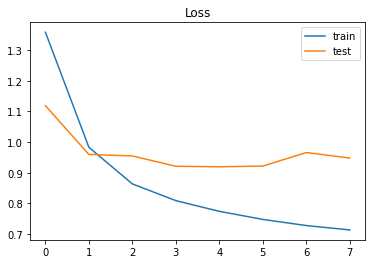

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

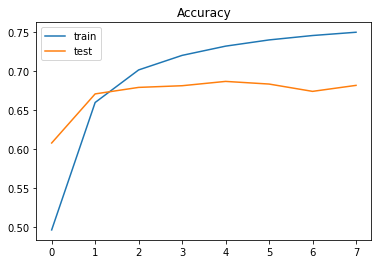

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();